# Introduction

New York City (NYC), the capital city of USA, is the most populous city of USA. NYC is growing as the famous international center of business, finance, arts and culture with population of 8,336,817 in 2019. And great NYC area continues to be the leading gateway for immigrants into USA. NYC has established many ethnic neighborhoods such as Chinatowns, Koreatowns, Little India, Greektown etc. 

This project will explore the best location for opening a new Indian restaurant across NYC area. As one of the most multicultural and diverse cities in the world, NYC has a great inclusiveness for diverse exotic food and different ethnical restaurants. Indian cuisine is an important part of the whole world cuisine, originating from distinct regions of India with a long history. The variety of Indian food is quite large with special favors.  The diversified color, aromatic flavor, as well as excellent taste makes the potential success of opening a new Indian restaurant especially in modern city like NYC. 

However, careful considerations of multiple relevant factors need to be required at the beginning. In particular, the location of the restaurant is one of the most important factors that will affect whether it will have success or a failure. Therefore, this project will answer two main questions: 1). Where should the investor open a new Indian restaurant? 2). Where to find a great Indian restaurant?

# Data
Based on the purpose of our project and solve the questions above, several datasets are needed:
1.	Datasets on NYC location data including neighborhoods, boroughs, longitudes will be obtained from the data sources: 
https://cocl.us/new_york_dataset
2.	Indian restaurants in NYC neighborhoods. 
Data will be obtained from Foursquare API and venues of Indian restaurants in NYC neighborhoods will be collected including restaurants’ ratings, tips, users likes. 
3.  GeoSpace data Data source:
By using this geo space data we will get the New york Borough boundaries that will help us visualize choropleth map.
https://data.cityofnewyork.us/City-Government/Borough-Boundaries/tqmj-j8zm. 

# Methods
1.	Collect the NYC data containing all of the neighborhood, postal code and boroughs from above datasets.
2.	Collect all venues of each neighborhood using Foursquare API and filter out all of venues for Indian restaurants. 
3.	Prepare data for machine learning: select data, preprocess data and transform data. 
4.	Data visualization, statistical analysis.
5.	 Analysis using clustering (K-means)
6.	Compare the neighborhoods to find the best place for opening a new Indian restaurant.
7.	Summary of Results and Conclusions. 

# Problems
1. Where should the investor open a new Indian restaurant? 
2. Where to find a great Indian restaurant?

# Data Analysis

In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import requests
import sys
from bs4 import BeautifulSoup
!pip install geocoder
import geocoder
import os
from geopy.geocoders import Nominatim 
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
!pip install folium==0.5
import folium

%matplotlib inline


print('Libraries imported.')

Libraries imported.


In [2]:
def geo_location(address):
 
    geolocator = Nominatim(user_agent="ny_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

In [3]:
def get_venues(lat,lng):
    
  
    radius=1000
    LIMIT=100
    CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5' 
    CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR' 
    VERSION = '20180605'
  
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    
   
    results = requests.get(url).json()
    venue_data=results["response"]['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
        
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    print("done")
    return df

In [4]:
def get_venue_details(venue_id):
        
    CLIENT_ID = 'ZMHWBS0SR12Z3YDYVHJVTZPRK3U1ZP3I2TYQAJ5CU3JUHMB5' 
    CLIENT_SECRET = 'H3TT0XT3P5TIAFCV1Y2UUVLF42N44DICNKLUELK34H2TKLFR' 
    VERSION = '20180605'
    
   
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    

    results = requests.get(url).json()
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
        
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

In [5]:
def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
  
    features=resp['features']
    
  
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
  
    new_york_data = pd.DataFrame(columns=column_names)
    
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
    
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    return new_york_data

In [6]:
new_york_data=get_new_york_data()
new_york_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [7]:
new_york_data.shape

(306, 4)

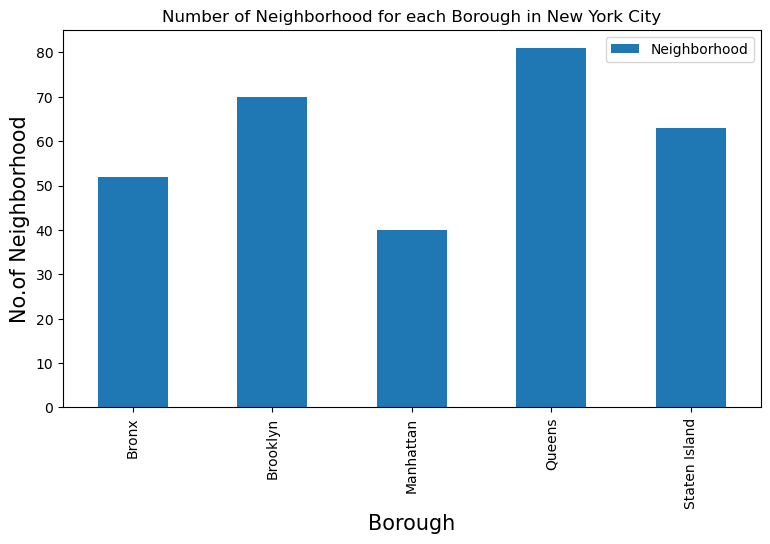

In [8]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Neighborhood for each Borough in New York City')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No.of Neighborhood', fontsize=15)
new_york_data.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.legend()
plt.show()

In [9]:
column_names=['Borough', 'Neighborhood', 'ID','Name']
indian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in new_york_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    indian_resturants=venues[venues['Category']=='Indian Restaurant']   
    print('(',count,'/',len(new_york_data),')','Indian Resturants in '+Neighborhood+', '+Borough+':'+str(len(indian_resturants)))
    for resturant_detail in indian_resturants.values.tolist():
        id, name , category=resturant_detail
        indian_rest_ny = indian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

done
( 1 / 306 ) Indian Resturants in Wakefield, Bronx:0
done
( 2 / 306 ) Indian Resturants in Co-op City, Bronx:0
done
( 3 / 306 ) Indian Resturants in Eastchester, Bronx:0
done
( 4 / 306 ) Indian Resturants in Fieldston, Bronx:0
done
( 5 / 306 ) Indian Resturants in Riverdale, Bronx:0
done
( 6 / 306 ) Indian Resturants in Kingsbridge, Bronx:0
done
( 7 / 306 ) Indian Resturants in Marble Hill, Manhattan:0
done
( 8 / 306 ) Indian Resturants in Woodlawn, Bronx:1
done
( 9 / 306 ) Indian Resturants in Norwood, Bronx:0
done
( 10 / 306 ) Indian Resturants in Williamsbridge, Bronx:0
done
( 11 / 306 ) Indian Resturants in Baychester, Bronx:0
done
( 12 / 306 ) Indian Resturants in Pelham Parkway, Bronx:0
done
( 13 / 306 ) Indian Resturants in City Island, Bronx:0
done
( 14 / 306 ) Indian Resturants in Bedford Park, Bronx:0
done
( 15 / 306 ) Indian Resturants in University Heights, Bronx:0
done
( 16 / 306 ) Indian Resturants in Morris Heights, Bronx:0
done
( 17 / 306 ) Indian Resturants in Ford

done
( 132 / 306 ) Indian Resturants in Jackson Heights, Queens:6
done
( 133 / 306 ) Indian Resturants in Elmhurst, Queens:3
done
( 134 / 306 ) Indian Resturants in Howard Beach, Queens:0
done
( 135 / 306 ) Indian Resturants in Corona, Queens:0
done
( 136 / 306 ) Indian Resturants in Forest Hills, Queens:0
done
( 137 / 306 ) Indian Resturants in Kew Gardens, Queens:2
done
( 138 / 306 ) Indian Resturants in Richmond Hill, Queens:9
done
( 139 / 306 ) Indian Resturants in Flushing, Queens:0
done
( 140 / 306 ) Indian Resturants in Long Island City, Queens:2
done
( 141 / 306 ) Indian Resturants in Sunnyside, Queens:1
done
( 142 / 306 ) Indian Resturants in East Elmhurst, Queens:0
done
( 143 / 306 ) Indian Resturants in Maspeth, Queens:0
done
( 144 / 306 ) Indian Resturants in Ridgewood, Queens:1
done
( 145 / 306 ) Indian Resturants in Glendale, Queens:0
done
( 146 / 306 ) Indian Resturants in Rego Park, Queens:1
done
( 147 / 306 ) Indian Resturants in Woodhaven, Queens:0
done
( 148 / 306 ) 

done
( 259 / 306 ) Indian Resturants in Elm Park, Staten Island:0
done
( 260 / 306 ) Indian Resturants in Remsen Village, Brooklyn:0
done
( 261 / 306 ) Indian Resturants in New Lots, Brooklyn:0
done
( 262 / 306 ) Indian Resturants in Paerdegat Basin, Brooklyn:0
done
( 263 / 306 ) Indian Resturants in Mill Basin, Brooklyn:0
done
( 264 / 306 ) Indian Resturants in Jamaica Hills, Queens:4
done
( 265 / 306 ) Indian Resturants in Utopia, Queens:0
done
( 266 / 306 ) Indian Resturants in Pomonok, Queens:0
done
( 267 / 306 ) Indian Resturants in Astoria Heights, Queens:1
done
( 268 / 306 ) Indian Resturants in Claremont Village, Bronx:0
done
( 269 / 306 ) Indian Resturants in Concourse Village, Bronx:1
done
( 270 / 306 ) Indian Resturants in Mount Eden, Bronx:0
done
( 271 / 306 ) Indian Resturants in Mount Hope, Bronx:0
done
( 272 / 306 ) Indian Resturants in Sutton Place, Manhattan:1
done
( 273 / 306 ) Indian Resturants in Hunters Point, Queens:0
done
( 274 / 306 ) Indian Resturants in Turtle

In [10]:
indian_rest_ny.head()

,Borough,Neighborhood,ID,Name
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill


In [11]:
indian_rest_ny.shape

(150, 4)

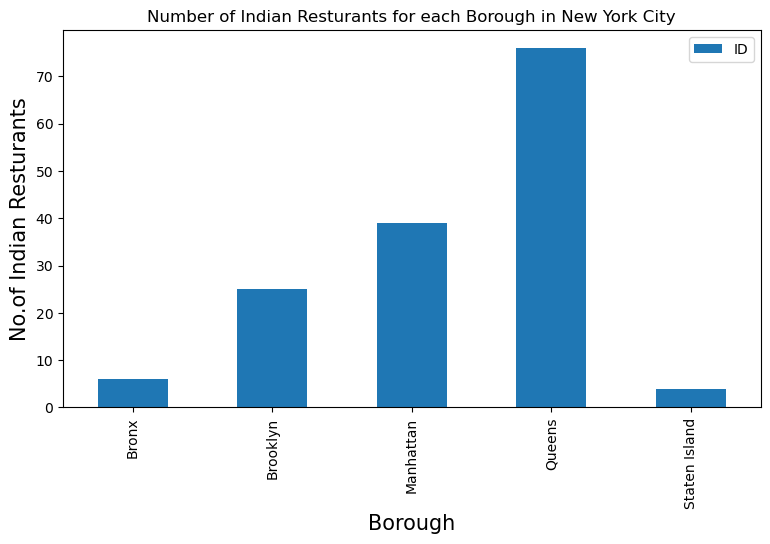

In [12]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Resturants for each Borough in New York City')

plt.xlabel('Borough', fontsize = 15)

plt.ylabel('No.of Indian Resturants', fontsize=15)

indian_rest_ny.groupby('Borough')['ID'].count().plot(kind='bar')

plt.legend()

plt.show()

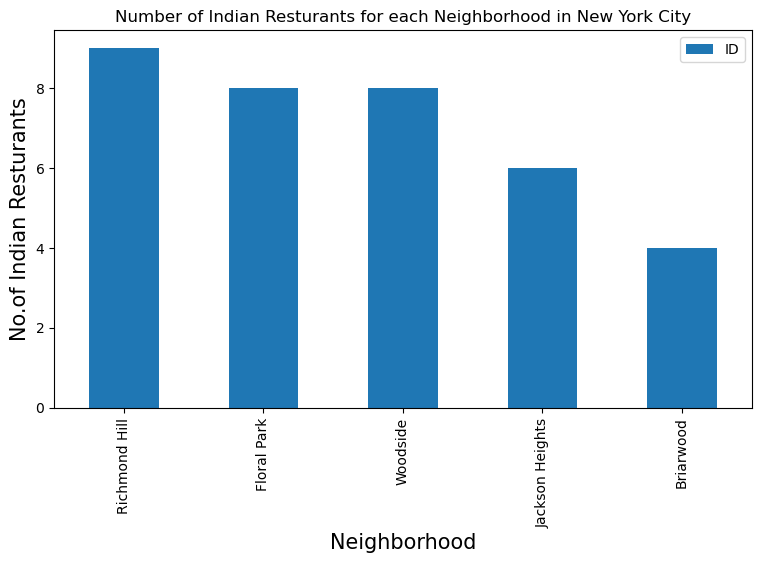

In [13]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Number of Indian Resturants for each Neighborhood in New York City')
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No.of Indian Resturants', fontsize=15)
indian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(5).plot(kind='bar')
plt.legend()
plt.show()

In [14]:
indian_rest_ny[indian_rest_ny['Neighborhood']=='Floral Park']

,Borough,Neighborhood,ID,Name
107,Queens,Floral Park,527ffc0811d2d329d5e49abd,Jackson Diner
108,Queens,Floral Park,4e4e3e22bd4101d0d7a5c2d1,Kerala Kitchen
109,Queens,Floral Park,4b647b56f964a520c4b62ae3,Usha Foods & Usha Sweets
110,Queens,Floral Park,4b787c49f964a5209cd12ee3,Santoor Indian Restaurant
111,Queens,Floral Park,4c0c01e0bbc676b00d6b4cd5,Mumbai Xpress
112,Queens,Floral Park,4c76ff35a5676dcb72671721,Flavor Of India
113,Queens,Floral Park,4df0f39dd4c04d0392c853ea,Sagar Chinese
114,Queens,Floral Park,4e6bfe1c7d8b2c711b17bbe5,Surya sweets and snacks


In [15]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
indian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1


for row in indian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(indian_rest_ny),')','processed')
    indian_rest_stats_ny = indian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1

                         ID        Name  Likes  Rating  Tips
0  4c0448d9310fc9b6bf1dc761  Curry Spot      5     7.7    10
( 1 / 150 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 2 / 150 ) processed
                         ID                  Name  Likes  Rating  Tips
0  4c04544df423a593ac83d116  Cumin Indian Cuisine     13     5.8     9
( 3 / 150 ) processed
                         ID         Name  Likes  Rating  Tips
0  551b7f75498e86c00a0ed2e1  Hungry Bird      8     7.0     3
( 4 / 150 ) processed
                         ID                         Name  Likes  Rating  Tips
0  4c194631838020a13e78e561  Melanies Roti Bar And Grill      3     6.3     2
( 5 / 150 ) processed
                         ID       Name  Likes  Rating  Tips
0  4b5a4dc8f964a520a2bb28e3  Taj Mahal     37     8.3    26
( 6 / 150 ) processed
                         ID          Name  Likes

                         ID       Name  Likes  Rating  Tips
0  5d8d9c5e0a2ffc0008f28855  The Gully      7     8.2     4
( 55 / 150 ) processed
                         ID                 Name  Likes  Rating  Tips
0  4aa56c81f964a5204e4820e3  Seva Indian Cuisine    241     8.6   133
( 56 / 150 ) processed
                         ID                Name  Likes  Rating  Tips
0  59b9d25d0d173f3bdf654d77  Tikka Indian Grill      6     8.3     4
( 57 / 150 ) processed
                         ID            Name  Likes  Rating  Tips
0  4afdcf29f964a520162b22e3  Rajbhog Sweets     36     8.5    25
( 58 / 150 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4b998d3ff964a520fc8235e3  Maharaja Sweets & Snacks     55     8.5    25
( 59 / 150 ) processed
                         ID      Name  Likes  Rating  Tips
0  4c7060e734443704ca0e245f  Kababish     30     7.8    18
( 60 / 150 ) processed
                         ID  Name  Likes  Rating  Tips
0  4b189424

                         ID            Name  Likes  Rating  Tips
0  4e4e3e22bd4101d0d7a5c2d1  Kerala Kitchen      6     8.2     6
( 109 / 150 ) processed
                         ID                      Name  Likes  Rating  Tips
0  4b647b56f964a520c4b62ae3  Usha Foods & Usha Sweets     35     8.0    10
( 110 / 150 ) processed
                         ID                       Name  Likes  Rating  Tips
0  4b787c49f964a5209cd12ee3  Santoor Indian Restaurant     37     7.4    18
( 111 / 150 ) processed
                         ID           Name  Likes  Rating  Tips
0  4c0c01e0bbc676b00d6b4cd5  Mumbai Xpress     16     6.7    18
( 112 / 150 ) processed
                         ID             Name  Likes  Rating  Tips
0  4c76ff35a5676dcb72671721  Flavor Of India      6     5.8     6
( 113 / 150 ) processed
                         ID           Name  Likes  Rating  Tips
0  4df0f39dd4c04d0392c853ea  Sagar Chinese      7     5.8     6
( 114 / 150 ) processed
Empty DataFrame
Columns: [ID, Name, 

In [16]:
indian_rest_stats_ny.shape

(150, 7)

In [17]:
indian_rest_ny.shape

(150, 4)

In [18]:
indian_rest_stats_ny.to_csv('indian_rest_stats_ny.csv', index=False)

In [19]:
indian_rest_stats_ny_csv=pd.read_csv('indian_rest_stats_ny.csv')

In [20]:
indian_rest_stats_ny_csv.shape

(150, 7)

In [21]:
indian_rest_stats_ny_csv.head()

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
0,Bronx,Woodlawn,4c0448d9310fc9b6bf1dc761,Curry Spot,5,7.7,10
1,Bronx,Parkchester,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2
2,Bronx,Spuyten Duyvil,4c04544df423a593ac83d116,Cumin Indian Cuisine,13,5.8,9
3,Bronx,Concourse,551b7f75498e86c00a0ed2e1,Hungry Bird,8,7.0,3
4,Bronx,Unionport,4c194631838020a13e78e561,Melanies Roti Bar And Grill,3,6.3,2


In [22]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       150 non-null    object 
 1   Neighborhood  150 non-null    object 
 2   ID            150 non-null    object 
 3   Name          150 non-null    object 
 4   Likes         150 non-null    object 
 5   Rating        150 non-null    float64
 6   Tips          150 non-null    object 
dtypes: float64(1), object(6)
memory usage: 8.3+ KB


In [23]:
indian_rest_stats_ny['Likes']=indian_rest_stats_ny['Likes'].astype('float64')

In [24]:
indian_rest_stats_ny['Tips']=indian_rest_stats_ny['Tips'].astype('float64')

In [25]:
indian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Borough       150 non-null    object 
 1   Neighborhood  150 non-null    object 
 2   ID            150 non-null    object 
 3   Name          150 non-null    object 
 4   Likes         150 non-null    float64
 5   Rating        150 non-null    float64
 6   Tips          150 non-null    float64
dtypes: float64(3), object(4)
memory usage: 8.3+ KB


In [26]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                831
Rating                               8.6
Tips                                 255
Name: 40, dtype: object

In [27]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Rating'].idxmax()]

Borough                         Brooklyn
Neighborhood            Prospect Heights
ID              592e1dae345cbe0fc77cf6c9
Name                         Diwan Grill
Likes                                 19
Rating                                 9
Tips                                   8
Name: 12, dtype: object

In [28]:
indian_rest_stats_ny.iloc[indian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Midtown
ID              49d91c12f964a520015e1fe3
Name               The Kati Roll Company
Likes                                831
Rating                               8.6
Tips                                 255
Name: 40, dtype: object

In [29]:
ny_neighborhood_stats=indian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']

In [30]:
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)

,Neighborhood,Average Rating
13,Civic Center,9.00
6,Blissville,9.00
68,Tribeca,9.00
65,Sunnyside,9.00
52,Prospect Heights,9.00
69,Tudor City,8.90
46,Murray Hill,8.90
74,West Village,8.80
43,Midtown,8.60
44,Midtown South,8.55


In [31]:
ny_borough_stats=indian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']

In [32]:
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
2,Manhattan,8.264103
4,Staten Island,8.050000
1,Brooklyn,7.736000
0,Bronx,6.683333
3,Queens,6.288158


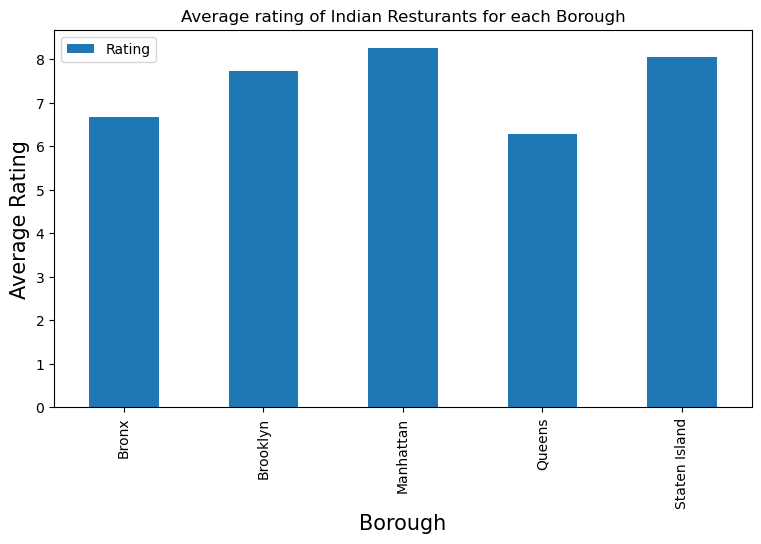

In [33]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Indian Resturants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
indian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar')
plt.legend()
plt.show()

In [34]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=9.0]

In [35]:
ny_neighborhood_stats

,Neighborhood,Average Rating
6,Blissville,9.0
13,Civic Center,9.0
52,Prospect Heights,9.0
65,Sunnyside,9.0
68,Tribeca,9.0


In [36]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,new_york_data, on='Neighborhood')

In [37]:
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]

In [38]:
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Queens,Blissville,40.737251,-73.932442,9.0
1,Manhattan,Civic Center,40.715229,-74.005415,9.0
2,Brooklyn,Prospect Heights,40.676822,-73.964859,9.0
3,Queens,Sunnyside,40.740176,-73.926916,9.0
4,Staten Island,Sunnyside,40.612760,-74.097126,9.0
5,Manhattan,Tribeca,40.721522,-74.010683,9.0


In [39]:
ny_map = folium.Map(location=geo_location('New York'), zoom_start=12)

In [40]:
incidents = folium.map.FeatureGroup()

for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    incidents.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, 
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

In [41]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'

In [42]:
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        

ny_map.add_child(incidents)

# Conclusion
1. Astoria(Queens), Blissville(Queens), Civic Center(Manhattan) are some of the best neighborhoods for indian cuisine.
2. Manhattan have potential Indian Resturant Market
3. Staten Island ranks last in average rating of Indian Resturants.
4. Manhattan is the best place to stay if you prefer Indian Cuisine.